#Mount Drive And Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Load library
!pip install -q wordcloud-fa
!pip install -q gensim
#import library
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
import re
import gensim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from keras.layers import Dropout,Embedding,GlobalMaxPool1D,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from wordcloud_fa import WordCloudFa
print("Tensorflow Version",tf.__version__)

     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 368kB 40.1MB/s 
     |████████████████████████████████| 317kB 45.2MB/s 
     |████████████████████████████████| 1.4MB 55.0MB/s 
     |████████████████████████████████| 235kB 37.5MB/s 
Tensorflow Version 2.5.0


#Load Dataset

In [ ]:
# # df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-test-10000.xlsx')
# # df.head()
# # df.describe

# df_train = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/train.xlsx')
# df_valid = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/dev.xlsx')
# df_test = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/test.xlsx')

In [3]:
#load dataset
df_train = pd.read_excel("/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/train.xlsx")
df_valid = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/dev.xlsx')
df_test_tweets = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/test.xlsx')
df_test_labels = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/offLabel.xlsx')

#Rename Columns
df_train = df_train.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_valid = df_valid.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_test_labels=df_test_labels.rename(columns={'labels':'OFF_Labels'})

df_test=pd.concat([df_test_tweets, df_test_labels], axis=1)

#drop any row have null values
df_train=df_train.dropna(how='any',axis=0)
df_valid=df_valid.dropna(how='any',axis=0)
# df_train.drop(columns=['HS_Labels'])
# df_valid.drop(columns=['HS_Labels'])
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(6983, 2)
(1000, 3)
(2000, 2)


In [ ]:
# df = df.drop(['hs','new_label'], axis=1)

Text(0.5, 1.0, 'Hate speech Data Distribution')

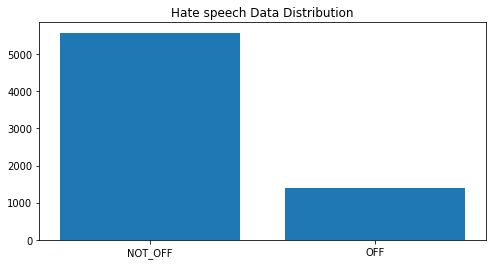

In [4]:
val_count = df_train.OFF_Labels.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Hate speech Data Distribution")

In [5]:
import random
random_idx_list = [random.randint(1,len(df_train.tweets)) for i in range(10)] # creates random indexes to choose from dataframe
df_train.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,tweets,OFF_Labels
3255,RT @USER: يا مقصدي بكل الحكي يا مُلهمي ب أجمل ...,NOT_OFF
4330,@USER @USER امين يا رب العالمين يفك كربك يا مر...,NOT_OFF
1383,@USER انت عايزه يقول ايه عن نيمار يعني يسطى؟ و...,NOT_OFF
3484,كلنا عيوب الا من ستر ربنا علينا <LF>ربنا يسترك...,NOT_OFF
5244,يا نعمة الله علي يا راحه قلبي وأمانه.,NOT_OFF
5023,"اللهم*صل*على*محمد*وآل*محمد*<LF>""اللهم إني وكلت...",NOT_OFF
4464,RT @USER: يا جماعه هو في راجل مراته هتروح التح...,OFF
4905,@USER انتي تعديتي مرحلة الانسان محتاجة زب حصان...,OFF
581,يا أنتِ<LF>يا عينيَّ يا أنشودتي<LF>يا بيتَ شِع...,NOT_OFF
2152,RT @USER: يا عبدالحي، يا عبدالحي تحرك قوم يا ع...,NOT_OFF


#Text Preprocessing¶


In [6]:
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"
def preprocess(text):
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  # text = re.sub("ؤ", "ء", text)
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    # if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [7]:
# preprocess('مشكوووور hello 156562سٌلمُ@#')
preprocess('_ salam # @  حمقى 12 ممتازة ياااااااارب ؟ ! سٌلمُ')

'حمقي ممتازه ياارب ؟ ! سلم'

In [8]:
df_train.tweets = df_train.tweets.apply(lambda x: preprocess(x))
df_valid.tweets = df_valid.tweets.apply(lambda x: preprocess(x))
df_test.tweets = df_test.tweets.apply(lambda x: preprocess(x))
# df.tweets[:10]

#Data Presentation

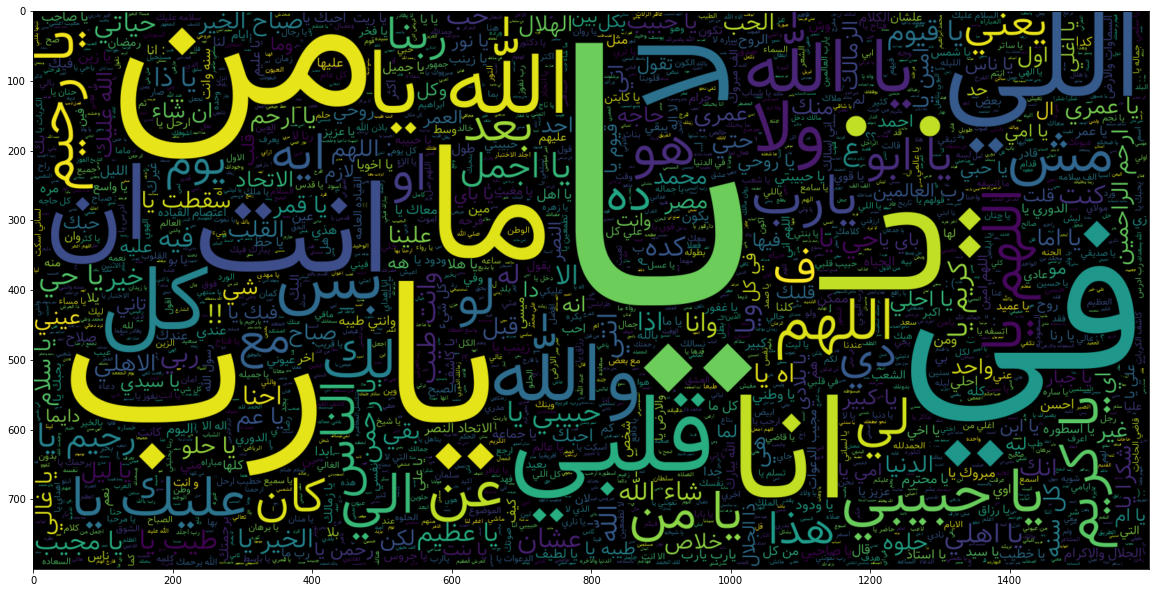

In [ ]:
#Not Offensive Words
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.OFF_Labels == 'NOT_OFF'].tweets))
image = wc.to_image()
image.save('wordcloud.png')
plt.imshow(wc , interpolation = 'bilinear')

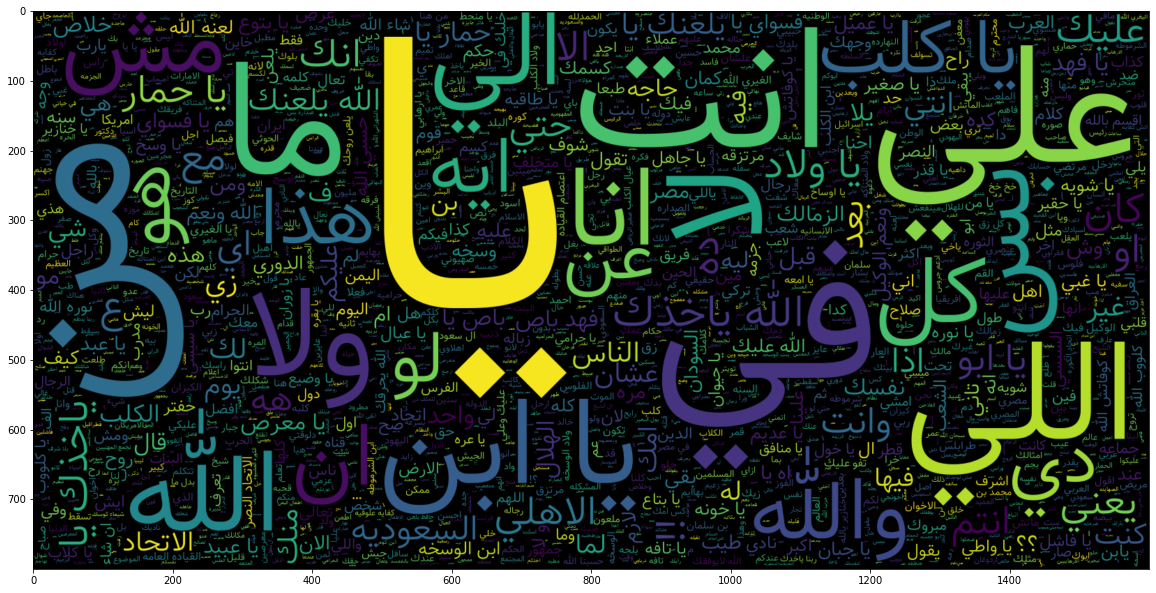

In [ ]:
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.OFF_Labels=='OFF'].tweets))
image = wc.to_image()
image.save('wordcloudoff.png')
plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [11]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300

In [12]:
# train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
#                                          random_state=7) # Splits Dataset into Training and Testing set
# print("Train Data size:", len(train_data))
# print("Test Data size", len(test_data))
# X_train, X_test, y_train, y_test = train_test_split(df.tweets,df.off, test_size = 0.2, random_state = 42, stratify=df.off)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 42, stratify=y_train)

# print("Train Data size:", len(X_train))
# print("Test Data size", len(X_test))
# print("Val Data size", len(X_val))

In [13]:
# train_data.head(10)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweets)
# tokenizer.fit_on_texts(X_test)
tokenizer.fit_on_texts(df_valid.tweets)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 35193


In [15]:

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweets),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(tokenizer.texts_to_sequences(df_valid.tweets),
                       maxlen = MAX_SEQUENCE_LENGTH)

X_test=pad_sequences(tokenizer.texts_to_sequences(df_test.tweets),maxlen=MAX_SEQUENCE_LENGTH)
print("Training X Shape:",X_train.shape)
print("Validation X Shape:",X_val.shape)
print("Testing X Shape:",X_test.shape)


Training X Shape: (6983, 300)
Validation X Shape: (1000, 300)
Testing X Shape: (2000, 300)


In [16]:
encoder = LabelEncoder()
encoder.fit(df_train.OFF_Labels.to_list())
# encoder.fit(y_val.to_list())
# encoder.fit(y_test.to_list())

y_train = encoder.transform(df_train.OFF_Labels.to_list())
y_val = encoder.transform(df_valid.OFF_Labels.to_list())
Y_test = encoder.transform(df_test.OFF_Labels.to_list())

y_train = y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", Y_test.shape)
print("y_val shape:", y_val.shape)


y_train shape: (6983, 1)
y_test shape: (2000, 1)
y_val shape: (1000, 1)


# Word embedding

In [17]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 30
# load the model
modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/Word Embedding/Twt-CBOW/Twt-CBOW')

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in modelwv.wv.vocab:
      embedding_vector = modelwv[word]
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [19]:
print(embedding_matrix.shape)
# EMBEDDING_DIM=300


(35193, 300)


In [20]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training - CNN

In [43]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Dropout(0.5)(embedding_sequences)

# Conv1D + global max pooling
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = Conv1D(64, 7, padding="valid", activation="relu", strides=3)(x)
# x = Conv1D(32, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(sequence_input, outputs)

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
# Adam(learning_rate=LR)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
# ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
#                                      min_lr = 0.01,
#                                      monitor = 'val_loss',
#                                      verbose = 1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
]

In [45]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/30
7/7 [==============================] - 2s 153ms/step - loss: 0.6425 - accuracy: 0.7950 - val_loss: 0.6001 - val_accuracy: 0.8160
Epoch 2/30
7/7 [==============================] - 1s 118ms/step - loss: 0.5601 - accuracy: 0.8157 - val_loss: 0.5741 - val_accuracy: 0.8150
Epoch 3/30
7/7 [==============================] - 1s 115ms/step - loss: 0.4961 - accuracy: 0.8516 - val_loss: 0.5563 - val_accuracy: 0.8180
Epoch 4/30
7/7 [==============================] - 1s 118ms/step - loss: 0.4270 - accuracy: 0.8757 - val_loss: 0.5456 - val_accuracy: 0.8090
Epoch 5/30
7/7 [==============================] - 1s 116ms/step - loss: 0.3608 - accuracy: 0.8936 - val_loss: 0.5526 - val_accuracy: 0.8110
Epoch 6/30
7/7 [==============================] - 1s 116ms/step - loss: 0.2970 - accuracy: 0.9102 - val_loss: 0.5760 - val_accuracy: 0.8010
Epoch 7/30
7/7 [==============================] - 1s 116ms/step - loss: 0.2484 - accuracy: 0.9237 - val_loss: 0.6245 - val_accuracy: 0.8010
Epoch 8/30
7/7 [====

In [46]:
scores = model.evaluate(X_train,y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print(y_train)

accuracy: 93.05%


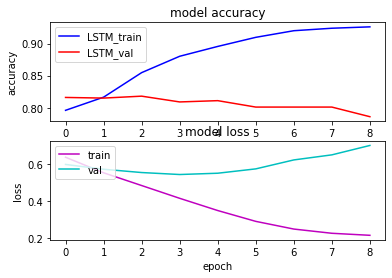

In [47]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [48]:
# evaluate the model
scorestest = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scorestest[1]*100))

accuracy: 79.90%


In [49]:
model.evaluate(X_test, Y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.5829 - accuracy: 0.7990


[0.5829415917396545, 0.7990000247955322]

#Confusion Matrix¶


In [50]:
def decode_sentiment(score):
    return "OFF" if (score>0.5).any() else "NOT_OFF"

scores = model.predict(X_test, verbose=1, batch_size=100)

scores.astype(np.float32)
type(scores)
y_pred_1d = np.array([decode_sentiment(score) for score in scores])
print(y_pred_1d[:10])
print(Y_test[:10])

20/20 [==============================] - 0s 9ms/step
['NOT_OFF' 'OFF' 'NOT_OFF' 'OFF' 'NOT_OFF' 'NOT_OFF' 'NOT_OFF' 'NOT_OFF'
 'NOT_OFF' 'NOT_OFF']
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [51]:
pred_new = []
for i in y_pred_1d:
  # print(i)
  if i == 'OFF':
    pred_new.append(1)
  else:
    pred_new.append(0)
print(pred_new)

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

In [52]:
print(classification_report(list(Y_test), pred_new))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1598
           1       0.50      0.07      0.13       402

    accuracy                           0.80      2000
   macro avg       0.65      0.53      0.51      2000
weighted avg       0.75      0.80      0.73      2000



In [42]:
# word = preprocess(u'حقير')
# model = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')
# # find and print the most similar terms to a word
# most_similar = model.wv.most_similar( word )
# for term, score in most_similar:
# 	print(term, score)
 
# word_vector = model.wv[ word ]